<a href="https://colab.research.google.com/github/sommnathrwategaonkar/MOPSO/blob/main/MOPSO_SRW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📥 Upload grayscale lung images (e.g., normal_001.png, abnormal_001.png)...


Saving 00018387_035.png to 00018387_035.png
Saving 00018387_036.png to 00018387_036.png
Saving 00018387_037.png to 00018387_037.png
Saving 00018388_000.png to 00018388_000.png
Saving 00018388_001.png to 00018388_001.png
Saving 00018388_002.png to 00018388_002.png
Saving 00018388_003.png to 00018388_003.png
Saving 00018388_004.png to 00018388_004.png
Saving 00018388_005.png to 00018388_005.png
Saving 00018389_000.png to 00018389_000.png
✅ 00018387_035.png: PSO Best Threshold = 0.8942 | Otsu = 0.4321


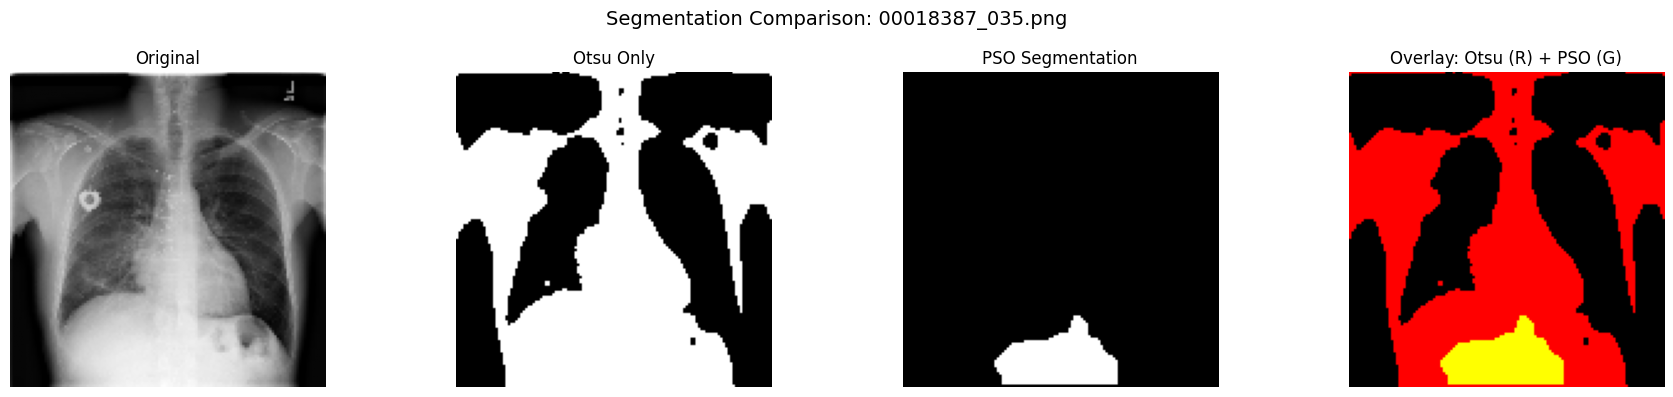

✅ 00018387_036.png: PSO Best Threshold = 0.1000 | Otsu = 0.5709


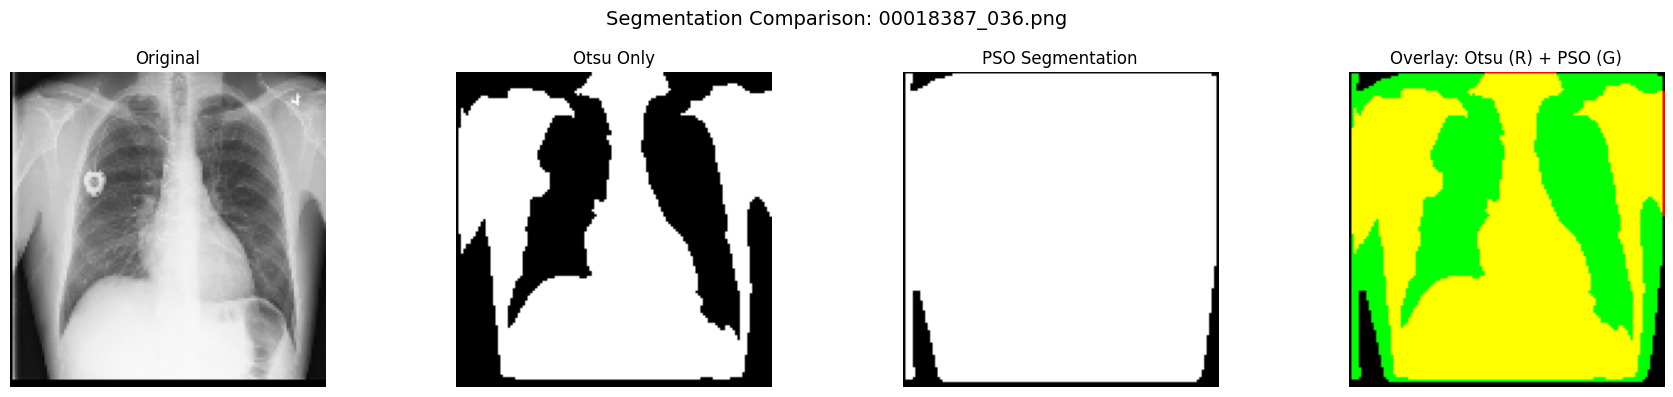

✅ 00018387_037.png: PSO Best Threshold = 0.9000 | Otsu = 0.4068


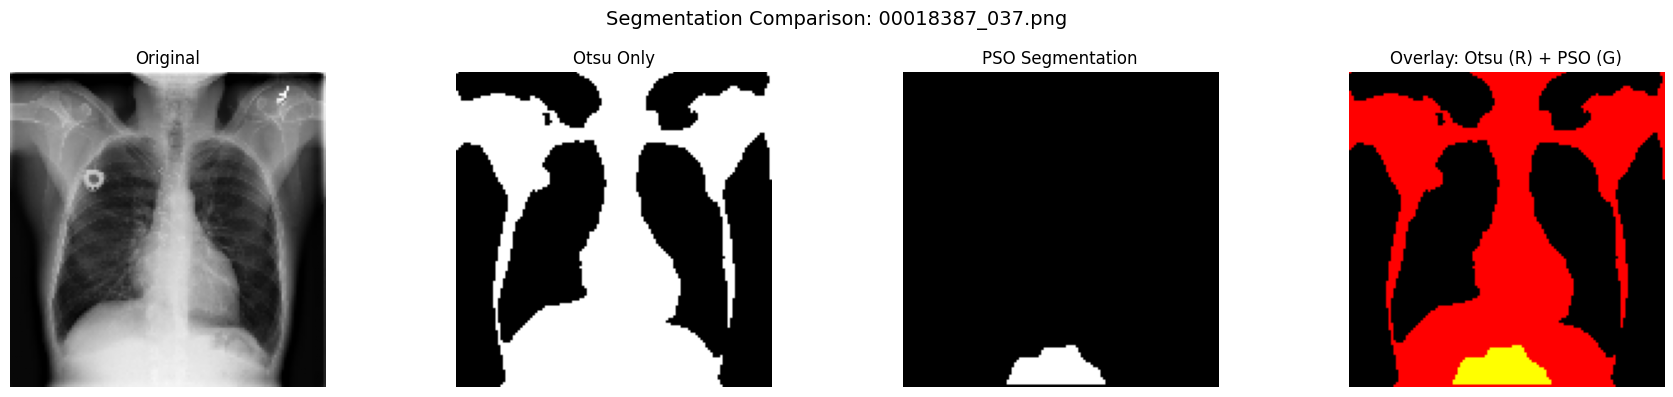

✅ 00018388_000.png: PSO Best Threshold = 0.7975 | Otsu = 0.5166


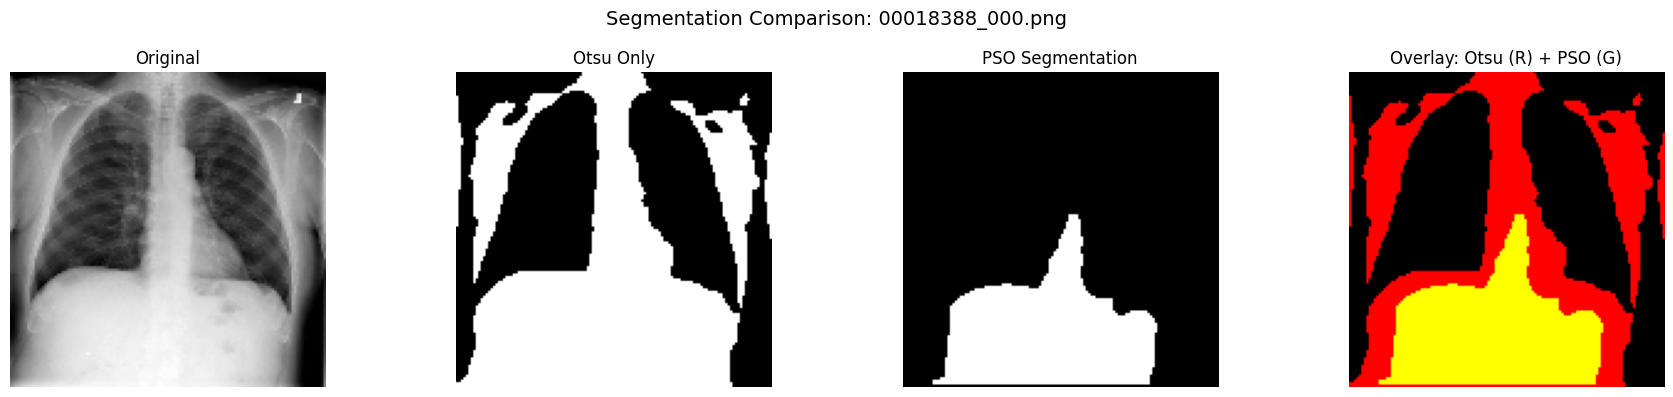

✅ 00018388_001.png: PSO Best Threshold = 0.8198 | Otsu = 0.4841


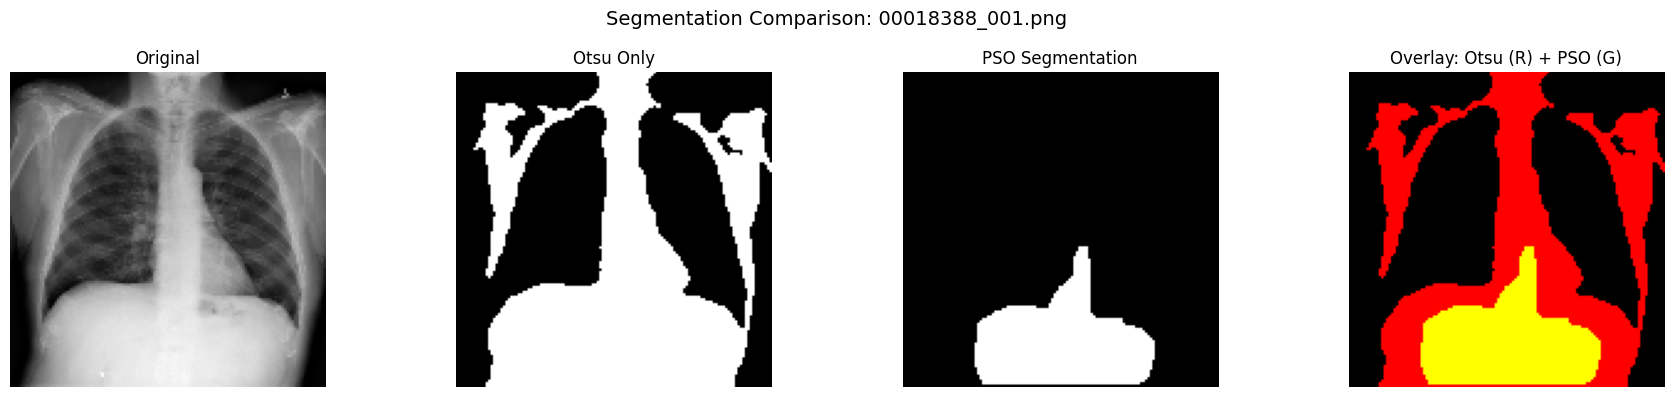

✅ 00018388_002.png: PSO Best Threshold = 0.1000 | Otsu = 0.5081


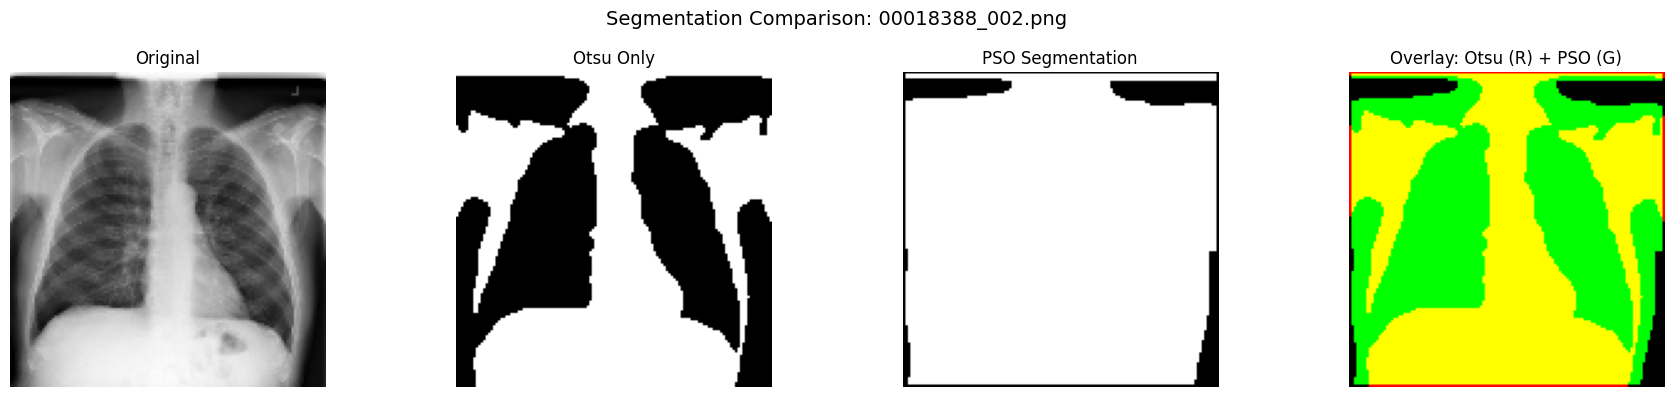

✅ 00018388_003.png: PSO Best Threshold = 0.1000 | Otsu = 0.4732


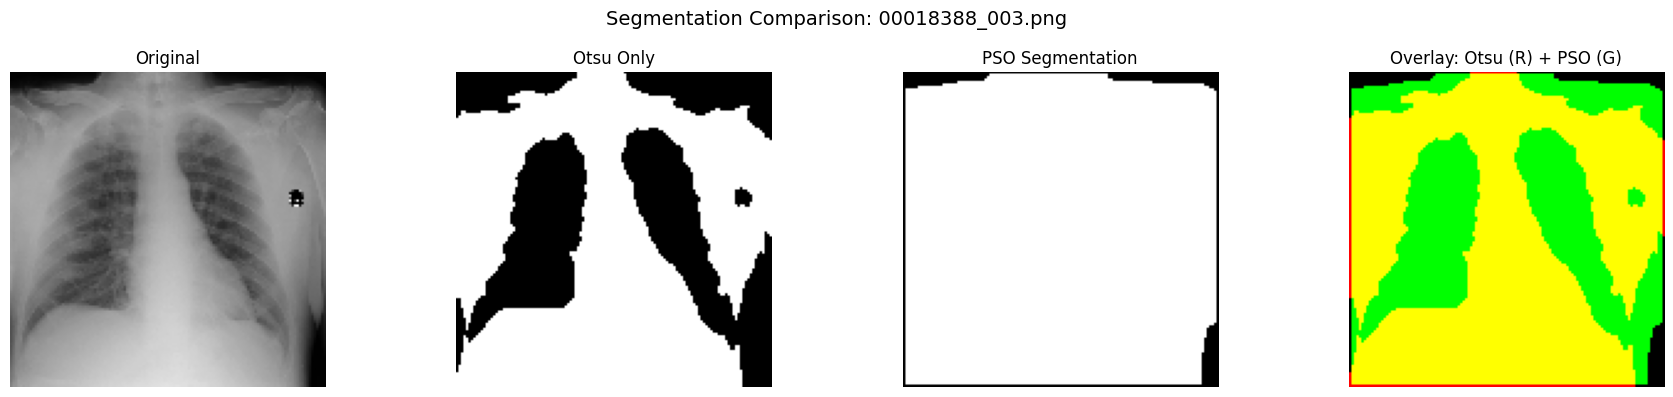

✅ 00018388_004.png: PSO Best Threshold = 0.1000 | Otsu = 0.4806


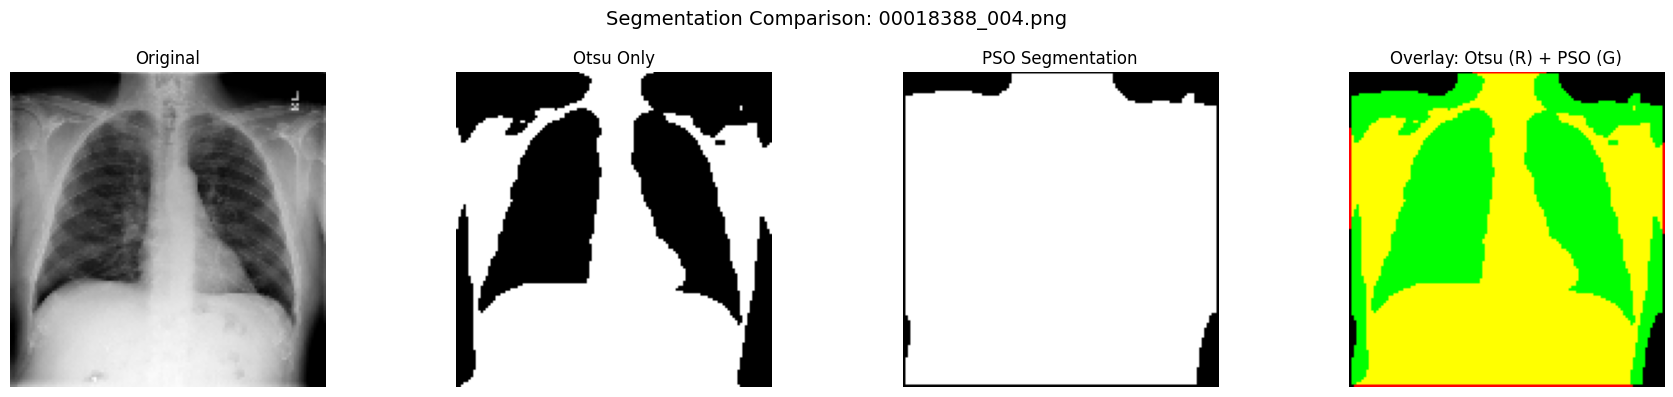

✅ 00018388_005.png: PSO Best Threshold = 0.7309 | Otsu = 0.5139


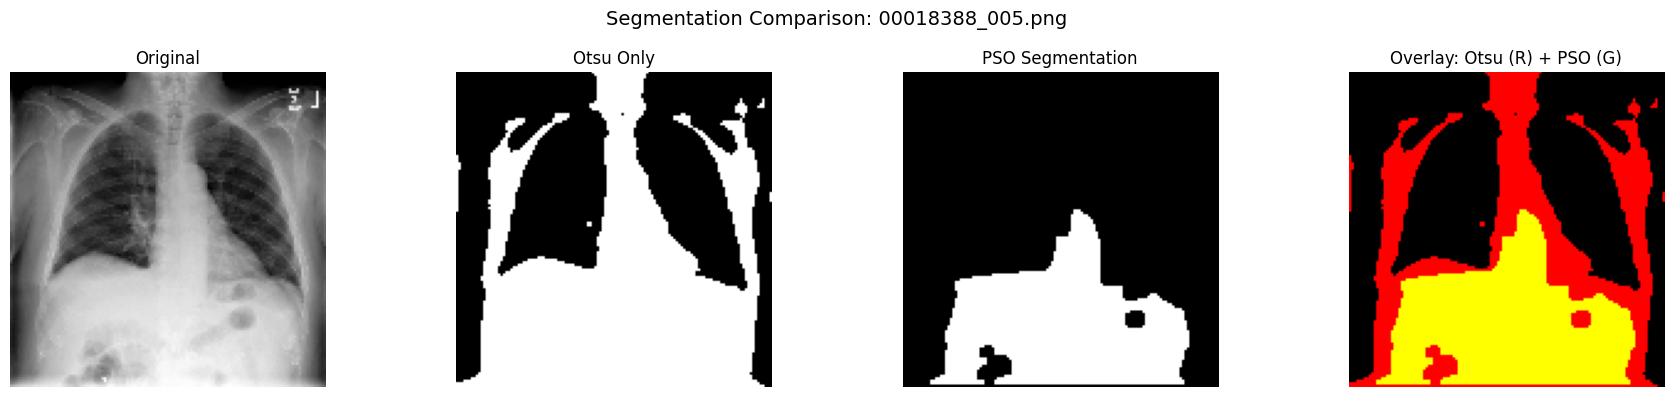

✅ 00018389_000.png: PSO Best Threshold = 0.1000 | Otsu = 0.5095


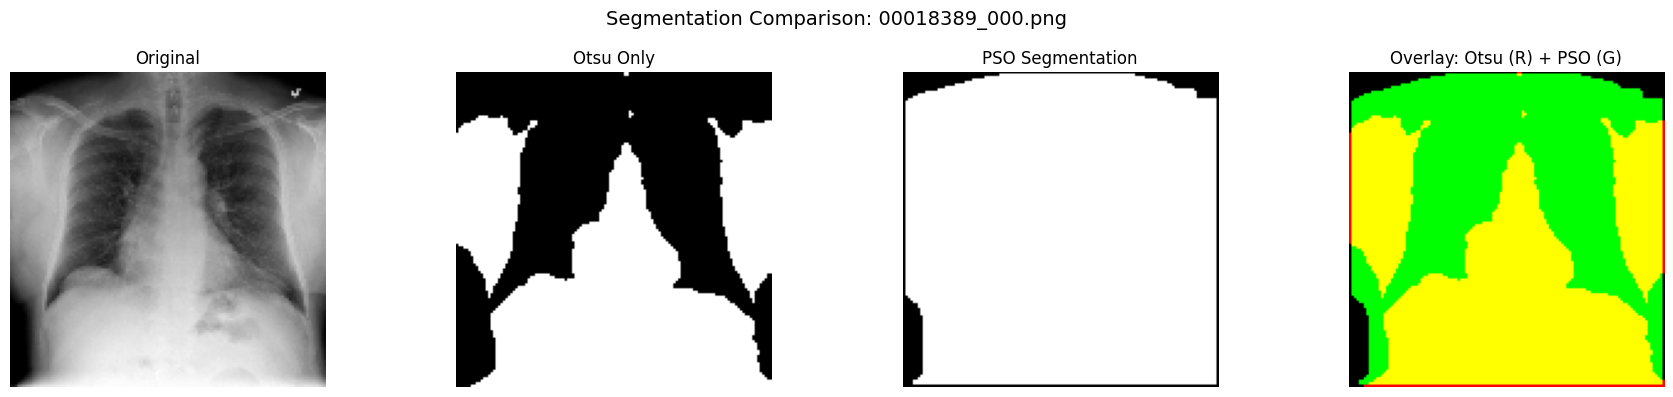


📊 Comparison Summary (Otsu vs PSO):
           Filename  Otsu_Accuracy  Otsu_Dice  Otsu_IoU  PSO_Accuracy  \
0  00018387_035.png            1.0        1.0       1.0         0.558   
1  00018387_036.png            1.0        1.0       1.0         0.637   
2  00018387_037.png            1.0        1.0       1.0         0.561   
3  00018388_000.png            1.0        1.0       1.0         0.694   
4  00018388_001.png            1.0        1.0       1.0         0.674   
5  00018388_002.png            1.0        1.0       1.0         0.554   
6  00018388_003.png            1.0        1.0       1.0         0.662   
7  00018388_004.png            1.0        1.0       1.0         0.604   
8  00018388_005.png            1.0        1.0       1.0         0.745   
9  00018389_000.png            1.0        1.0       1.0         0.554   

   PSO_Dice  PSO_IoU  
0     0.198    0.110  
1     0.760    0.613  
2     0.110    0.058  
3     0.574    0.403  
4     0.460    0.299  
5     0.684    0.520 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os, cv2, numpy as np, matplotlib.pyplot as plt, pandas as pd
from google.colab import files
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing
from skimage.filters import threshold_otsu
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# ✅ PSO Particle Class
class Particle:
    def __init__(self, bounds):
        self.position = np.random.uniform(*bounds)
        self.velocity = 0
        self.best_position = self.position
        self.best_score = float('-inf')

    def evaluate(self, image):
        mask = image > self.position
        compactness = -np.var(image[mask])
        separability = np.mean(image[mask]) - np.mean(image[~mask])
        score = 0.3 * compactness + 0.7 * separability
        return score, mask

def multiobjective_pso(image, n_particles=10, iters=20):
    particles = [Particle((0.1, 0.9)) for _ in range(n_particles)]
    gbest_score, gbest_position = float('-inf'), particles[0].position
    for _ in range(iters):
        for p in particles:
            score, _ = p.evaluate(image)
            if score > p.best_score:
                p.best_score, p.best_position = score, p.position
            if score > gbest_score:
                gbest_score, gbest_position = score, p.position
        for p in particles:
            r1, r2 = np.random.rand(), np.random.rand()
            p.velocity = 0.5 * p.velocity + 1.5 * r1 * (p.best_position - p.position) + 1.5 * r2 * (gbest_position - p.position)
            p.position = np.clip(p.position + p.velocity, 0.1, 0.9)
    pred_mask = image > gbest_position
    pred_mask = binary_opening(pred_mask, structure=np.ones((3,3)))
    pred_mask = binary_closing(pred_mask, structure=np.ones((3,3)))
    return pred_mask, gbest_position

# ✅ Evaluation Function
def evaluate(gt, pred, prob):
    yt = gt.flatten().astype(int)
    yp = pred.flatten().astype(int)
    yprob = ((prob - prob.min()) / (prob.max() - prob.min())).flatten()
    cm = confusion_matrix(yt, yp)
    auc = roc_auc_score(yt, yprob)
    report = classification_report(yt, yp, digits=3, output_dict=True)
    acc = report['accuracy']
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']
    intersection = np.logical_and(gt, pred)
    union = np.logical_or(gt, pred)
    iou = np.sum(intersection) / (np.sum(union) + 1e-6)
    dice = 2 * np.sum(intersection) / (np.sum(gt) + np.sum(pred) + 1e-6)
    return acc, auc, precision, recall, f1, dice, iou

# ✅ Visual Comparison
def plot_overlay(img, mask1, mask2, fname):
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    axs[0].imshow(img, cmap='gray'); axs[0].set_title("Original"); axs[0].axis('off')
    axs[1].imshow(mask1, cmap='gray'); axs[1].set_title("Otsu Only"); axs[1].axis('off')
    axs[2].imshow(mask2, cmap='gray'); axs[2].set_title("PSO Segmentation"); axs[2].axis('off')
    overlay = np.zeros((*img.shape, 3))
    overlay[..., 0] = mask1
    overlay[..., 1] = mask2
    axs[3].imshow(overlay); axs[3].set_title("Overlay: Otsu (R) + PSO (G)"); axs[3].axis('off')
    plt.suptitle(f"Segmentation Comparison: {fname}", fontsize=14)
    plt.tight_layout(); plt.show()

# ✅ Upload + Compare PSO vs Otsu
def upload_and_compare():
    print("📥 Upload grayscale lung images (e.g., normal_001.png, abnormal_001.png)...")
    uploaded = files.upload()
    results = []

    for fname in uploaded:
        try:
            img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128)).astype(np.float32)
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
            smoothed = gaussian_filter(img, sigma=1)

            otsu_thresh = threshold_otsu(smoothed)
            otsu_mask = smoothed > otsu_thresh

            pso_mask, best_thresh = multiobjective_pso(smoothed)

            print(f"✅ {fname}: PSO Best Threshold = {best_thresh:.4f} | Otsu = {otsu_thresh:.4f}")
            plot_overlay(img, otsu_mask, pso_mask, fname)

            acc1, auc1, p1, r1, f1, d1, iou1 = evaluate(otsu_mask, otsu_mask, smoothed)
            acc2, auc2, p2, r2, f2, d2, iou2 = evaluate(otsu_mask, pso_mask, smoothed)

            results.append({
                "Filename": fname,
                "Otsu_Accuracy": acc1, "Otsu_Dice": d1, "Otsu_IoU": iou1,
                "PSO_Accuracy": acc2, "PSO_Dice": d2, "PSO_IoU": iou2
            })

        except Exception as e:
            print(f"❌ Error with {fname}: {e}")

    if results:
        df = pd.DataFrame(results)
        df.to_csv("comparison_results.csv", index=False)
        print("\n📊 Comparison Summary (Otsu vs PSO):")
        print(df.round(3))
        files.download("comparison_results.csv")
    else:
        print("⚠️ No images processed. No CSV created.")

# ✅ Run
upload_and_compare()


